In [1]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from PIL import Image
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore")

device=  ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



cuda:0


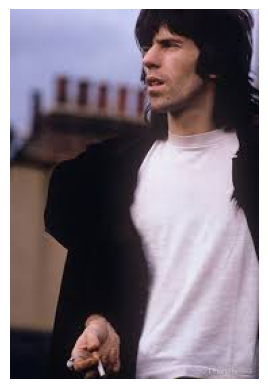

In [2]:
labels = ['keith','not_keith']


keith = Image.open('C:/cv/keith/keith/image8.jpeg')
plt.imshow(keith)
plt.axis("off")
plt.show()

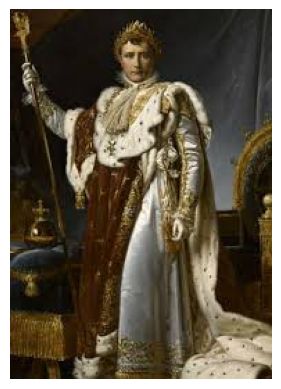

In [3]:
napolean = Image.open("C:/cv/keith/not_keith/napolean.jpg")
plt.imshow(napolean)
plt.axis("off")
plt.show()

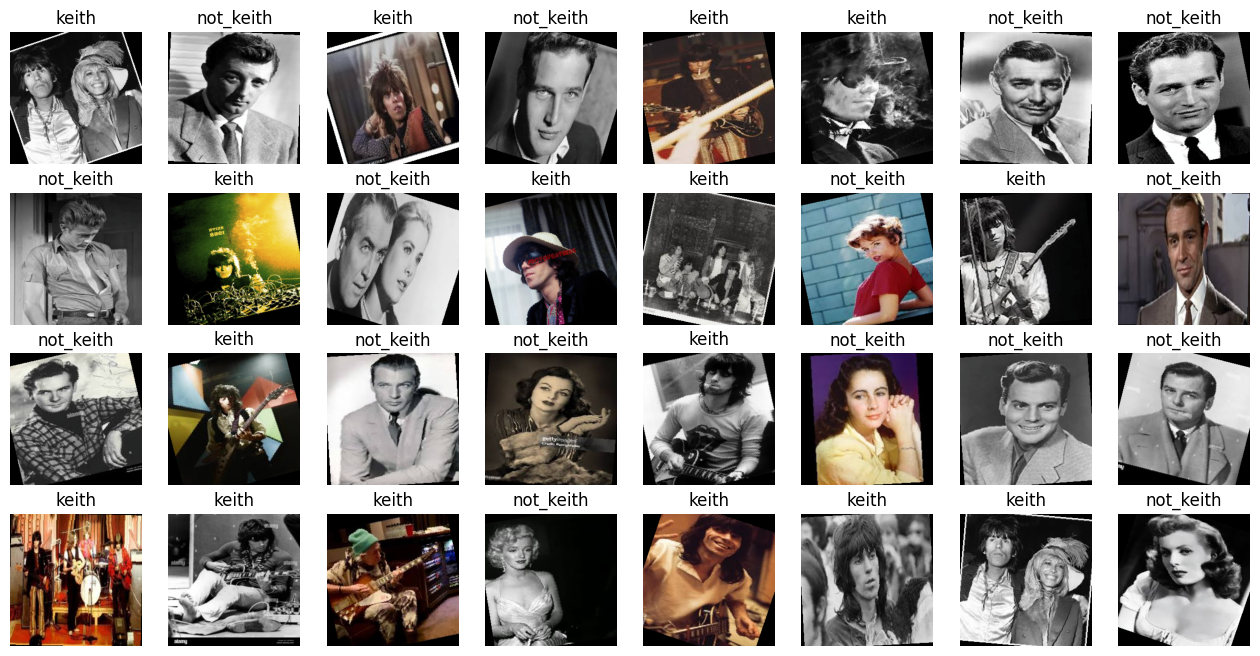

In [4]:

transformed_data = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def img_inv(image):
    image = image.numpy().transpose((1,2,0))
    image = image * std + mean
    return np.clip(image,0,1)




dataset = datasets.ImageFolder("C:/cv/keith/",transform=transformed_data)




train_split = int(len(dataset) * 0.8)
test_split = len(dataset) - train_split

train_data,test_data = random_split(dataset, lengths=[train_split,test_split])


BATCH_SIZE = 64
epochs = 10
learning_rate = 0.001


train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)




images,labels = next(iter(train_dataloader))



fig,axs = plt.subplots(4,8,figsize=(16,8))

for i,ax in enumerate(axs.flat):
    image = img_inv(images[i])
    ax.imshow(image)
    ax.set_title(dataset.classes[labels[i]])
    ax.axis("off")
plt.show()

In [5]:

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


for param in model.layer4.parameters():
    param.requires_grad = True




num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,2)
)

model.to(device)










optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()




for epoch in range(epochs):
    running_loss = 0.0
    for i,(images,labels) in enumerate(train_dataloader):
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader):.4f}")


Epoch [1/10], Loss: 0.7947
Epoch [2/10], Loss: 0.3109
Epoch [3/10], Loss: 0.2075
Epoch [4/10], Loss: 0.0832
Epoch [5/10], Loss: 0.0232
Epoch [6/10], Loss: 0.0265
Epoch [7/10], Loss: 0.0076
Epoch [8/10], Loss: 0.0109
Epoch [9/10], Loss: 0.0035
Epoch [10/10], Loss: 0.0062


In [6]:


model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images,labels in test_dataloader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,preds = torch.max(outputs.data,1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        
test_acc = 100 * correct / total
print(F"Testing Accuracy: {test_acc:.2f}%")




clf_rpt = classification_report(y_true,y_pred)
print(f"Classification Report: {clf_rpt}")


Testing Accuracy: 93.02%
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.92      0.96      0.94        23

    accuracy                           0.93        43
   macro avg       0.93      0.93      0.93        43
weighted avg       0.93      0.93      0.93        43



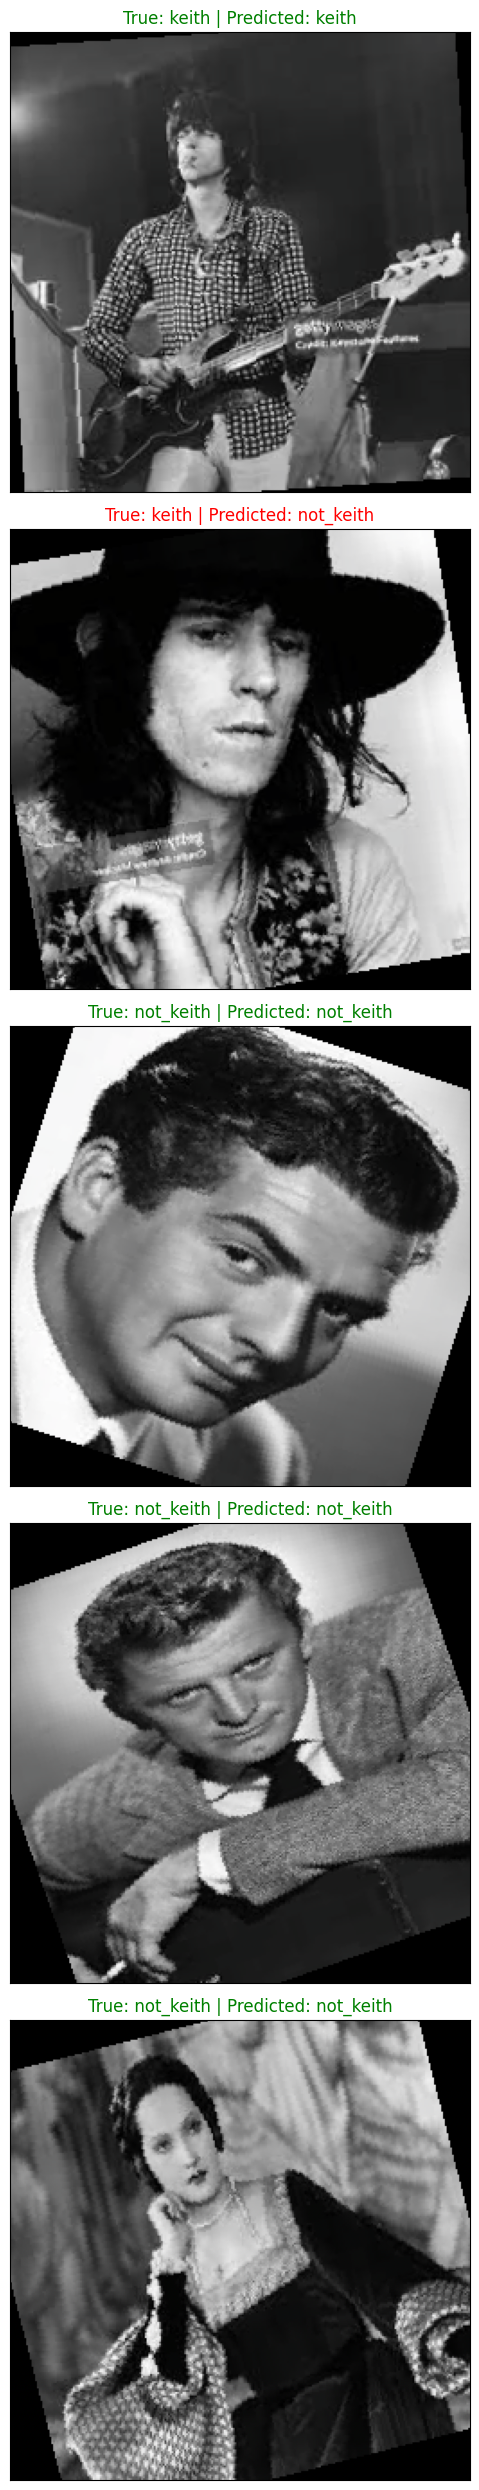

In [7]:



rand_indices = np.random.choice(len(y_pred), size=min(5, len(y_pred)), replace=False)
plt.figure(figsize=(10, 5 * len(rand_indices)))
for i, index in enumerate(rand_indices):
    image = img_inv(test_data[index][0])
    plt.subplot(len(rand_indices),1, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    predicted_class = dataset.classes[y_pred[index]]
    true_class = dataset.classes[y_true[index]]
    color = 'green' if predicted_class == true_class else 'red'
    plt.title(f'True: {true_class} | Predicted: {predicted_class}', color=color, fontsize=12)

plt.tight_layout()
plt.show()
